<a href="https://colab.research.google.com/github/alexshtf/alexshtf.github.io/blob/master/assets/shape_constrained_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install batch-iter
%pip install optuna

In [ ]:
import torch
from torch import nn

# Bernstein shape-constrained module

In [ ]:
def log_binom_coef(n: torch.Tensor, k: torch.Tensor):
  return (
      torch.lgamma(n + 1)
      - torch.lgamma(k + 1)
      - torch.lgamma(n - k + 1)
  )

In [ ]:
n = torch.tensor(5)
k = torch.arange(6)
print(log_binom_coef(n, k).exp())

tensor([ 1.,  5., 10., 10.,  5.,  1.])


In [ ]:
def bernstein_basis(degree: int, z: torch.Tensor):
  """
  Computes a matrix containing the Bernstein basis of a given degree, where
  each row corresponds to an entry in the input tensor `z`.
  """

  # entries of `z` in rows, and basis indices in columns
  z = z.view(-1, 1)
  ks = torch.arange(degree + 1, device=z.device).view(1, -1)

  # degree in a tensor to call log_binom_coef
  degree_tensor = torch.as_tensor(degree, device=z.device)

  # now we compute the Bernstein basis by definition
  binom_coef = torch.exp(log_binom_coef(degree_tensor, ks))
  return binom_coef * (z ** ks) * ((1 - z) ** (degree_tensor - ks))

In [ ]:
from torch import nn

class BernsteinPolynomialModel(nn.Module):
  def __init__(self, x_model, coef_transformer):
    super().__init__()
    self.x_model = x_model
    self.coef_transformer = coef_transformer

  def forward(self, x, z):
    coefs = self.coef_transformer(self.x_model(x))
    degree = coefs.shape[-1] - 1
    basis = bernstein_basis(degree, z)
    return torch.sum(coefs * basis, dim=-1)

# Additional coefficient transform layers

In [ ]:
class NondecreasingCoefTransform(nn.Module):
    def forward(self, u):
        # We assume that `u` has mini-batch dimensions,
        # and the 'coefficient' dimension is the last one.
        u_head = u[... ,0:1]
        u_tail_relu = nn.functional.softplus(u[..., 1:])
        head_tail = torch.cat([u_head, u_tail_relu], dim=-1)
        return torch.cumsum(head_tail, dim=-1)

In [ ]:
class NonincreasingCoefTransform(nn.Module):
    def forward(self, u):
        # We assume that `u` has mini-batch dimensions,
        # and the 'coefficient' dimension is the last one.
        u_head = u[... ,0:1]
        u_tail_relu = -nn.functional.softplus(u[..., 1:])
        head_tail = torch.cat([u_head, u_tail_relu], dim=-1)
        return torch.cumsum(head_tail, dim=-1)

In [ ]:
class CDFCoefTransform(nn.Module):
  def forward(self, u):
    zero = torch.zeros_like(u[..., :1])
    cum_softmax = torch.cumsum(nn.functional.softmax(u, dim=-1), dim=-1)
    cdf_coefs = torch.cat([zero, cum_softmax], dim=-1)
    return cdf_coefs

In [ ]:
print(NondecreasingCoefTransform()(torch.tensor([-5, 3., 2., -1., 3.])))

tensor([-5.0000, -1.9514,  0.1755,  0.4888,  3.5374])


In [ ]:
print(NonincreasingCoefTransform()(torch.tensor([-5, 3., 2., -1., 3.])))

tensor([ -5.0000,  -8.0486, -10.1755, -10.4888, -13.5374])


In [ ]:
print(CDFCoefTransform()(torch.tensor([-5, 3., 2., -1., 3.])))

tensor([0.0000e+00, 1.4056e-04, 4.1916e-01, 5.7331e-01, 5.8098e-01, 1.0000e+00])


# Fitting increasing function

In [ ]:
import numpy as np

def relu(x):
  return np.maximum(np.zeros_like(x), x)

def softshrink(x, a=0.3):
  return relu(x - a) - relu(-x - a)

def sgn_square(x):
  return x * np.abs(x)

def hairy_increasing_func(x, z):
  x1, x2, x3 = x[..., 0], x[..., 1], x[..., 2]
  return (relu(np.cos(x1 - x2 + x3)) * sgn_square(softshrink(z - np.sin(x1) ** 2))
          + (1 + np.cos(x2 + x3)) * sgn_square(softshrink(z - np.sin(x2) ** 2))
          + (1 + np.cos(x1 - x2)) * sgn_square(softshrink(z - np.sin(x3) ** 2))
          + np.cos(x1 + x2 + x3))

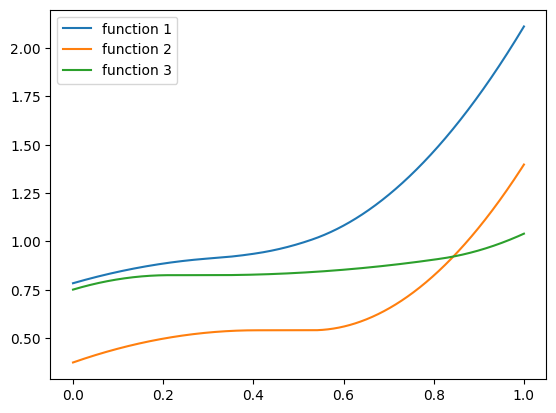

In [ ]:
import matplotlib.pyplot as plt

zs = np.linspace(0, 1, 1000)
plt.plot(zs, hairy_increasing_func(np.array([-1, 0.1, 0.5]), zs), label='function 1')
plt.plot(zs, hairy_increasing_func(np.array([1, 0.5, -0.5]), zs), label='function 2')
plt.plot(zs, hairy_increasing_func(np.array([-1.5, 0.8, 0.1]), zs), label='function 3')
plt.legend()
plt.show()

In [ ]:
def make_model(layer_dims, monotone=True):
  # create a fully connected ReLU network
  layers = [
      layer
      for in_dim, out_dim in zip(layer_dims[:-1], layer_dims[1:])
      for layer in [nn.Linear(in_dim, out_dim), nn.ReLU()]
  ]

  if monotone:
    # define a model for x
    x_model = nn.Sequential(*layers[:-1])

    # construct a network for predicting non-decreasing functions
    # the polynomial degree is the output dimension of the last
    # layer.
    return BernsteinPolynomialModel(
        x_model,
        NondecreasingCoefTransform()
    )
  else:
    layers.append(nn.Linear(layer_dims[-1], 1))
    return nn.Sequential(*layers)

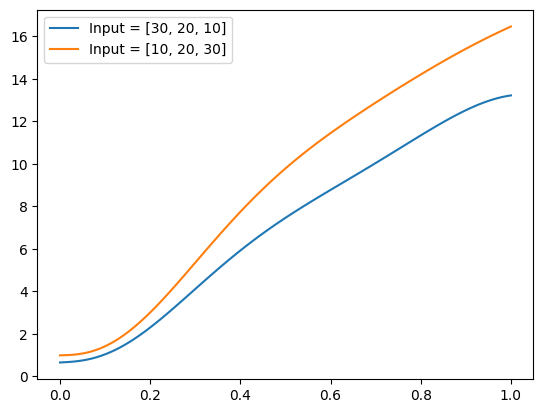

In [ ]:
from functools import partial
torch.manual_seed(2024)  # just to make this result reproducible
net = make_model([3, 10, 10, 10])

plot_zs = torch.linspace(0, 1, 100)

func = partial(net, torch.tensor([30., 20, 10]).repeat(100, 1))
plt.plot(plot_zs, func(plot_zs).detach().numpy(), label='Input = [30, 20, 10]')

func = partial(net, torch.tensor([10., 20, 30]).repeat(100, 1))
plt.plot(plot_zs, func(plot_zs).detach().numpy(), label='Input = [10, 20, 30]')

plt.legend()
plt.show()

In [ ]:
from tqdm.auto import tqdm

def train_epoch(data_iter, model, loss_fn, optim, monotone):
  for x, z, label in data_iter:
    if monotone:
      pred = model(x, z)
    else:
      pred = model(torch.cat([x, z.reshape(-1, 1)], dim=-1)).squeeze()
    loss = loss_fn(pred, label)

    optim.zero_grad()
    loss.backward()
    optim.step()


@torch.no_grad()
def valid_epoch(data_iter, model, loss_fn, monotone):
  epoch_loss = 0.
  num_samples = 0
  for x, z, label in data_iter:
    if monotone:
      pred = model(x, z)
    else:
      pred = model(torch.cat([x, z.reshape(-1, 1)], dim=-1)).squeeze()
    loss = loss_fn(pred, label)
    epoch_loss += loss * label.size(0)
    num_samples += label.size(0)
  return epoch_loss.cpu().item() / num_samples


def train_model(train_iter, valid_iter, layer_dims, monotone=True,
                optim_fn=torch.optim.SGD, optim_params=None, num_epochs=100):
  if optim_params is None:
    optim_params = {}

  torch.manual_seed(2024)
  model = make_model(layer_dims, monotone=monotone)
  optim = optim_fn(model.parameters(), **optim_params)
  loss_fn = nn.MSELoss()

  if torch.cuda.is_available():
    model = model.cuda()

  with tqdm(range(num_epochs)) as epoch_range:
    for epoch in epoch_range:
      train_epoch(train_iter, model, loss_fn, optim, monotone)
      epoch_loss = valid_epoch(valid_iter, model, loss_fn, monotone)
      epoch_range.set_description(f'Validation loss = {epoch_loss:.5f}')
  return model, epoch_loss

In [ ]:
def generate_dataset(n_rows, noise=0.1):
  xs = np.random.randn(n_rows, 3)
  zs = np.random.rand(n_rows)
  labels = hairy_increasing_func(xs, zs) + np.random.randn(n_rows) * noise

  xs = torch.as_tensor(xs).to(dtype=torch.float32)
  zs = torch.as_tensor(zs).to(dtype=torch.float32)
  labels = torch.as_tensor(labels).to(dtype=torch.float32)
  if torch.cuda.is_available():
    xs = xs.cuda()
    zs = zs.cuda()
    labels = labels.cuda()

  return xs, zs, labels

In [ ]:
from batch_iter import BatchIter

batch_size = 256
train_iter = BatchIter(*generate_dataset(50000), batch_size=batch_size)
valid_iter = BatchIter(*generate_dataset(10000), batch_size=batch_size)

In [ ]:
lr = 3e-3
weight_decay = 1e-5
degree = 50
layer_dims = [3,
              4 * degree,
              3 * degree,
              2 * degree,
              degree]
model, val_loss = train_model(
    train_iter, valid_iter, layer_dims,
    optim_fn=torch.optim.AdamW,
    optim_params=dict(lr=lr, weight_decay=weight_decay))
model = model.cpu()

  0%|          | 0/100 [00:00<?, ?it/s]

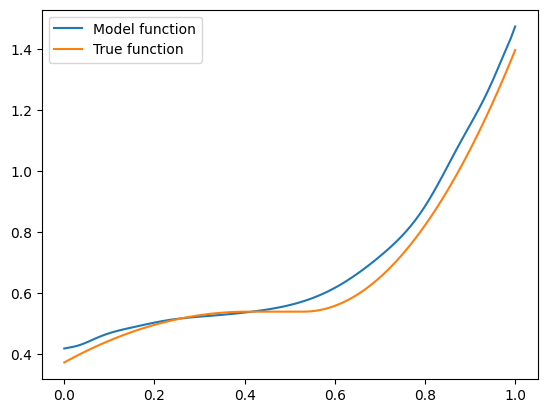

In [ ]:
features = torch.tensor([1, 0.5, -0.5]).repeat(100, 1)
func = partial(model, features)
plt.plot(plot_zs, func(plot_zs).detach().numpy(), label='Model function')
plt.plot(plot_zs, hairy_increasing_func(features.numpy(), plot_zs.numpy()), label='True function')

plt.legend()
plt.show()

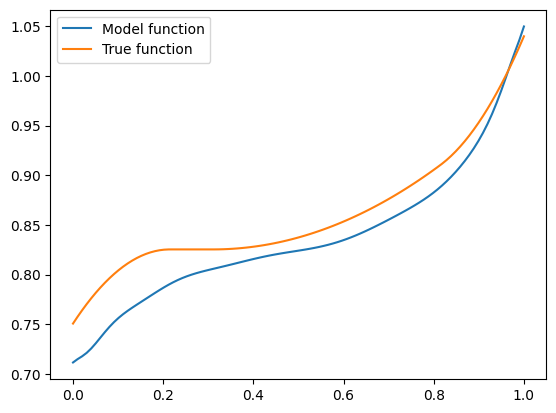

In [ ]:
features = torch.tensor([-1.5, 0.8, 0.1]).repeat(100, 1)
func = partial(model, features)
plt.plot(plot_zs, func(plot_zs).detach().numpy(), label='Model function')
plt.plot(plot_zs, hairy_increasing_func(features.numpy(), plot_zs.numpy()), label='True function')

plt.legend()
plt.show()

In [ ]:
lr = 3e-3
weight_decay = 1e-5
degree = 50
layer_dims = [4,
              4 * degree,
              3 * degree,
              2 * degree,
              degree]
model, val_loss = train_model(
    train_iter, valid_iter, layer_dims, monotone=False,
    optim_fn=torch.optim.AdamW,
    optim_params=dict(lr=lr, weight_decay=weight_decay))
model = model.cpu()

  0%|          | 0/100 [00:00<?, ?it/s]

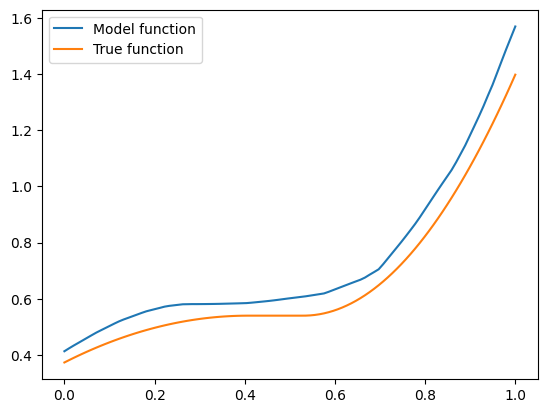

In [ ]:
features = torch.cat([
    torch.tensor([1, 0.5, -0.5]).repeat(100, 1),
    plot_zs.reshape(-1, 1)
], axis=-1)
plt.plot(plot_zs, model(features).detach().numpy(), label='Model function')
plt.plot(plot_zs, hairy_increasing_func(features.numpy(), plot_zs.numpy()), label='True function')

plt.legend()
plt.show()

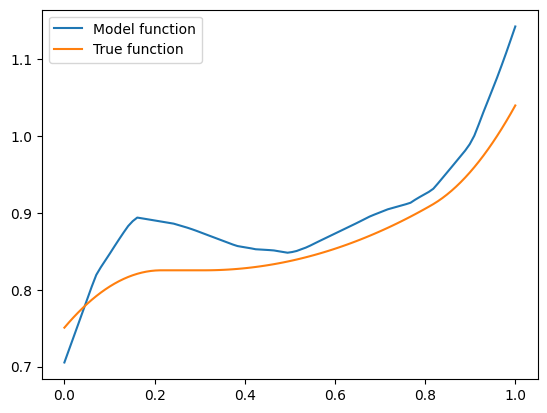

In [ ]:
features = torch.cat([
    torch.tensor([-1.5, 0.8, 0.1]).repeat(100, 1),
    plot_zs.reshape(-1, 1)
], axis=-1)
plt.plot(plot_zs, model(features).detach().numpy(), label='Model function')
plt.plot(plot_zs, hairy_increasing_func(features.numpy(), plot_zs.numpy()), label='True function')

plt.legend()
plt.show()